In [64]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

class PARSE_DATA:
    def __init__(self,folder , WIDTH=512 , HEIGHT=512 , train_test_split=0.7 , patch_hr_size=64 , limit=500):
        '''
        The specific dimensions because the lowest resolution image in the dataset has this
        '''
        self.patch_hr_size = patch_hr_size
        assert (WIDTH % self.patch_hr_size == 0),"Give a Height and Width divisible by "+str(self.patch_hr_size)+" and lower than 2k like (1024,768) , (512,384), (256,192)"
        
        folder = folder+"/HQf"
        self.HEIGHT = HEIGHT
        self.WIDTH = WIDTH
        self.CHANNEL = 3
        self.train_split = train_test_split
        self.test_split = 1 - self.train_split
        image_data = []
        for directory in os.listdir(folder):
            for file in os.listdir(folder+'/'+directory):
                if file.split('.')[1] == 'jpg':
                    if len(image_data) >= limit:
                        break
                    name = folder+'/'+directory+'/'+file
                    img = plt.imread(name)
                    img = cv2.resize(img, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
                    image_data.append(img)
        image_data = np.asarray(image_data,np.uint8)
        self.image_data = np.reshape(image_data , (len(image_data) , self.HEIGHT , self.WIDTH , self.CHANNEL ))
        image_flip_data = np.flip(image_data, axis=2)
        self.data = np.concatenate((image_data,image_flip_data) , axis=0)
        
        self.train_data = self.data[:int(self.data.shape[0]*self.train_split)]
        self.test_data = self.data[int(self.data.shape[0]*self.train_split):]
        
    def salt_pepper_noise(self,image):
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
          # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
        out[coords] = 0
        return out
    
#     def avg_pool(self , img):
#         r = int(img.shape[0]/4)
#         c = int(img.shape[1]/4)
#         im = np.zeros((r,c))
#         for R in range(0,r):
#             for C in range(0,c):
#                 im[R][C] = np.mean(img[R*4:R*4+4,C*4:C*4+4])
#         return im
                
    
    def get_train_data_X(self):
        return self.train_data,self.train_data
    
    def reconstruct(self,images,var = 'hr' , downscale = 2):
        assert var == 'hr' or var == 'lr' , "give proper reconstruction argument hr or lr"
        r = self.r
        c = self.c
        p = self.patch_hr_size
        if var == 'hr':
            im = np.zeros((self.HEIGHT,self.WIDTH,3))
        elif var == 'lr':
            im = np.zeros((int(self.HEIGHT/downscale) , int(self.WIDTH/downscale),3))
            p = int(self.patch_hr_size/downscale)
        i = 0
        for R in range(0,r):
            for C in range(0,c):
                    im[R*p:(R+1)*p,C*p:(C+1)*p] = images[i]
                    i=i+1
        im = np.array(im,np.uint8)
        return im
            
    
    def get_train_patchwise_data(self,downscale = 2,noisy = True , blur_kernel=(3,3)):
        assert downscale % 2 == 0 , "Enter proper multiple of 2 downscale"
        train_data_Y = []
        train_data_X_noisy = []
        train_data_X_non_noisy = []
        r = int(self.HEIGHT / self.patch_hr_size)
        c = int(self.WIDTH / self.patch_hr_size)
        self.r = r
        self.c = c
        self.patch_count = r*c
        p = int(self.patch_hr_size/downscale)
        for im in self.train_data:
            img = cv2.blur(im , blur_kernel) ## Blur filter
            img = self.salt_pepper_noise(im) ## salt pepper noise
            img[img > 20] = img[img > 20] - 20 
            img = cv2.resize(img, dsize=(int(self.WIDTH/downscale), int(self.HEIGHT/downscale)), interpolation=cv2.INTER_CUBIC)
            im_lr = cv2.resize(im, dsize=(int(self.WIDTH/downscale), int(self.HEIGHT/downscale)), interpolation=cv2.INTER_CUBIC)
            # above method needs to be changed
            for R in range(0,r):
                for C in range(0,c):
                    train_data_Y.append(im[R*self.patch_hr_size:R*self.patch_hr_size+self.patch_hr_size,C*self.patch_hr_size:C*self.patch_hr_size+self.patch_hr_size])
                    train_data_X_noisy.append(img[R*p:(R+1)*p,C*p:(C+1)*p])
                    train_data_X_non_noisy.append(im_lr[R*p:(R+1)*p,C*p:(C+1)*p])
        if noisy :
            train_data_Y += train_data_Y
            train_data_X_non_noisy += train_data_X_noisy
        train_data_Y = np.array(train_data_Y,np.uint8)
        train_data_X = np.array(train_data_X_non_noisy,np.uint8)
        train_data_X_bicubic = np.array([cv2.resize(img, dsize=(img.shape[1]*downscale, img.shape[0]*downscale), interpolation=cv2.INTER_CUBIC) for img in train_data_X])
        return train_data_X,train_data_X_bicubic,train_data_Y


In [65]:
a = PARSE_DATA(folder = "sibling-face-data/DBs", WIDTH=256 , HEIGHT=256,limit = 1)
X,Xb,Y = a.get_train_patchwise_data(downscale = 2 , noisy=True)


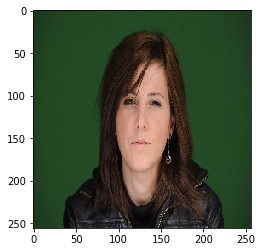

In [70]:
plt.imshow(a.reconstruct(Y[:a.patch_count],var='hr' ,downscale=2))

In [73]:
a.

(32, 64, 64, 3)